In [ ]:
import pandas as pd
import glob
import pyBigWig
import seaborn as sns
import re
import numpy as np
data='/labs/mpsnyder/moqri/data/meth/wg/mice/'
mm_='http://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.chromAlias.txt'
ez_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE94nnn/GSE94300/suppl/GSE94300_E14Ezh2_MAnorm_unbiased.bed.gz'
h_='http://smithdata.usc.edu/methbase/data/Stadler-Mouse-2011/Mouse_ESC/tracks_mm10/Mouse_ESC.meth.bw'
meta_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE80nnn/GSE80672/matrix/GSE80672_series_matrix.txt.gz'

In [ ]:
h=pyBigWig.open(h_)
h1=h.intervals("chr"+str(1))
print(len(h1))
h1=pd.DataFrame(h1)
h1.index=h1[1]
h1=h1[2]
h1l=h1[h1<.2]
h1l.shape

mm=pd.read_table(mm_,index_col=1)
mm.columns=['','','ch']
meta=pd.read_table(meta_,skiprows=34,header=None).T
meta=meta[meta[5]=='Whole Blood']
meta=meta[meta[11]=='genetic condition: Wild Type']
meta['gsm']=meta[46].str[3:]
meta['age']=meta[9].str.strip('age (years): ').astype(float)
meta.index=meta.gsm

all_files = glob.glob(data + "*.gz")
li = []
for f in all_files:
    gsm=f.split('GSM')[1].split('_')[0]
    if gsm in meta.gsm.tolist():
        print('',end='-')
        df= pd.read_table(f, index_col=None, header=0, usecols=[1])
        df.columns=[gsm]
        li.append(df)
df = pd.concat(li, axis=1)

In [3]:
#df.to_csv(data+'m.csv')

In [101]:
ezs=[]
ez=pd.read_table(ez_,header=None)
ez.columns=['chrom', 'chromStart', 'chromEnd']
print(ez.shape)
for ch in range(1,20):
    ezc=ez[ez['chrom']=='chr'+str(ch)]
    print(len(ezc),end=',')
    ezc['r']=ezc.apply(lambda x:range(x['chromStart'],x['chromEnd']),1)
    ezc=ezc['r'].tolist()
    ezc=set([item for sublist in ezc for item in sublist])   
    print(len(ezc),end='-')
    for b in ezc:
        ezs.append([str(ch),b])


ezs=pd.DataFrame(ezs)
ezs.columns=['ch','pos']
ezs['ez']=True
m= pd.read_table(all_files[0], index_col=None, header=0)
m.columns=['i','p','c']
m['m_ch']=m.i.str.split('|').str[3]
m['pos']=m.i.str.split('|').str[4].str.strip(':').astype(int)
ma=m.merge(mm[['ch']],left_on='m_ch',right_index=True)
me=ma.merge(ezs,left_on=['ch','pos'],right_on=['ch','pos'],how='left')
me.shape

mez=me[me.pos.isin(ezs.pos)]

(7213, 3)
462,526102-

/home/moqri/anaconda3/envs/stem/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


687,899107-337,395428-455,508115-474,596826-400,520490-438,488638-400,473660-374,426816-293,335768-536,651924-332,389072-351,426337-286,369904-320,377446-155,193966-266,307134-252,284005-227,286329-

<ipython-input-102-e5b44a5896f2>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([df.loc[mez.index].mean(),meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

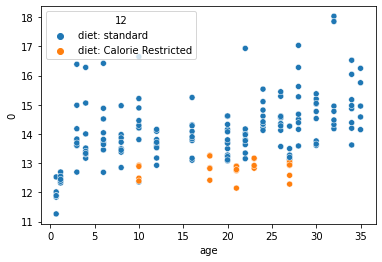

In [102]:
dg=pd.concat([df.loc[mez.index].mean(),meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg[dg[0]<20],x='age',y=0,hue=12)

In [266]:
dff=df[df['2132713']>.5]

<ipython-input-267-917fb3a435ad>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([dff[~dff.index.isin(mez.index)].mean(),meta[[12,'age']].loc[dff.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

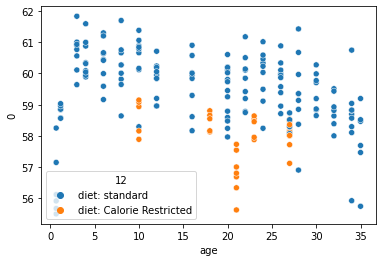

In [267]:
dg=pd.concat([dff[~dff.index.isin(mez.index)].mean(),meta[[12,'age']].loc[dff.columns]],1)
sns.scatterplot(data=dg,x='age',y=0,hue=12)

<ipython-input-108-20b30214c75a>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([ss,meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

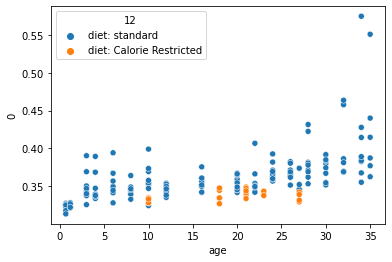

In [108]:
ss=df.loc[mez.index].mean()/df[~df.index.isin(mez.index)].mean()
dg=pd.concat([ss,meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg,x='age',y=0,hue=12)

<AxesSubplot:xlabel='age', ylabel='0'>

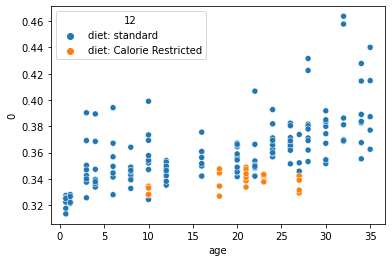

In [112]:
sns.scatterplot(data=dg[dg[0]<.5],x='age',y=0,hue=12)

In [160]:
mms=[]
for ch in range(1,20):
    ch1='https://hgdownload.soe.ucsc.edu/goldenPath/mm10/chromosomes/chr'+str(ch)+'.fa.gz'
    dt=pd.read_table(ch1)
    s=''.join(dt.iloc[:,0].values)
    wcgw=[]
    for st in ['ACGA','ACGT','TCGA','TCGT','AGCA','AGCT','TGCA','TGCT']:
        r=re.finditer(st,s)
        for i in r:
            wcgw.append(i.start())
    print(len(wcgw))
    so=pd.DataFrame(wcgw)
    so.columns=['0']
    so=so.sort_values(['0'])
    so['d']=so['0'].shift(1)
    so['u']=so['0'].shift(-1)
    so['+']=so['0']-so['d']
    so['-']=np.abs(so['0']-so['u'])
    so['m']=so[['+','-']].min(1)
    m1=me[me.ch==str(ch)]
    m1s=m1[m1.pos.isin(so['0']+2)|m1.pos.isin(so['0']+3)]
    mms.append(m1s)

2370293
2389811
1881862
1898846
1932228
1847066
1746783
1691675
1623914
1613274
1671677
1519519
1519315
1549852
1323157
1217111
1197027
1142790
798472


In [161]:
mmss=pd.concat(mms)

In [168]:
mmss.shape

(126792, 7)

<ipython-input-162-5e6b2789f42c>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([df[df.index.isin(mmss.index)].mean(),meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

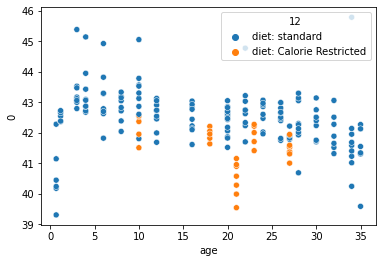

In [162]:
dg=pd.concat([df[df.index.isin(mmss.index)].mean(),meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg,x='age',y=0,hue=12)

<ipython-input-228-5f5b75a21b25>:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  dg=pd.concat([ss,meta[[12,'age']].loc[df.columns]],1)


<AxesSubplot:xlabel='age', ylabel='0'>

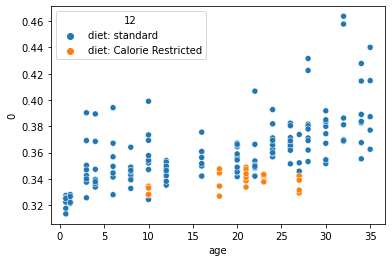

In [228]:
ss=df.loc[mez.index].mean()/df[~df.index.isin(mez.index)].mean()
dg=pd.concat([ss,meta[[12,'age']].loc[df.columns]],1)
sns.scatterplot(data=dg[dg[0]<.5],x='age',y=0,hue=12)

In [230]:
dg[dg[0]<.5].corr()

,0,age
0,1.000000,0.552649
age,0.552649,1.000000


In [91]:
lam_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62683/suppl/GSE62683_Normalized_data.txt.gz'
lamm_='https://ftp.ncbi.nlm.nih.gov/geo/platforms/GPL8nnn/GPL8840/suppl/GPL8840_080429_MM9_LP_Tiling_HX1.ndf.gz'
lam=pd.read_table(lam_,index_col=0)

In [92]:
lam=lam[['LmA_wt_1','LmA_wt_2']]

In [93]:
lam=lam.max(1)

In [94]:
lamm=pd.read_table(lamm_,index_col=0)

In [95]:
lamm.index=lamm.PROBE_ID

In [96]:
lamm=lamm[lamm.DESIGN_NOTE=='chr17']

In [97]:
lamm=lamm.sort_values('POSITION')

In [98]:
lamm=lamm[lamm.POSITION<15000000]

In [238]:
lamm['m']=lam.loc[lamm.index]

In [240]:
lamm.index=lamm.POSITION

<AxesSubplot:xlabel='POSITION'>

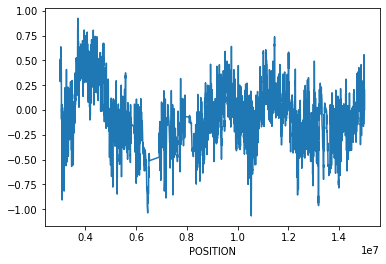

In [241]:
lamm.m.rolling(10).mean().plot()

In [250]:
df

,2132715,2132824,2132721,2132935,2132748,2132754,2132846,2132850,2132884,2132752,...,2132729,2132851,2132951,2132866,2132949,2132856,2132938,2132860,2132831,2132840
0,100.000000,100.000000,89.743590,100.000000,94.444444,94.736842,100.000000,97.619048,96.428571,84.615385,...,95.121951,96.774194,100.000000,100.000000,97.260274,100.000000,96.000000,100.000000,91.176471,94.444444
1,3.773585,9.090909,6.250000,20.000000,7.352941,10.344828,11.940299,17.708333,7.500000,16.000000,...,1.785714,16.666667,17.777778,5.454545,6.666667,25.000000,9.677419,12.244898,10.000000,11.904762
2,100.000000,100.000000,100.000000,97.560976,96.296296,100.000000,93.750000,97.619048,100.000000,100.000000,...,100.000000,96.774194,96.969697,97.142857,97.260274,100.000000,96.000000,87.500000,100.000000,88.888889
3,15.094340,12.121212,15.625000,26.000000,23.529412,24.137931,13.432836,18.750000,22.500000,20.000000,...,10.714286,16.666667,22.222222,25.454545,20.833333,13.461538,19.354839,10.204082,16.000000,16.666667
4,3.448276,14.705882,7.500000,12.195122,6.896552,13.636364,14.285714,10.588235,15.625000,3.846154,...,15.217391,3.333333,17.647059,22.857143,5.333333,16.216216,7.692308,20.833333,14.285714,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976970,100.000000,98.648649,99.122807,95.522388,93.043478,94.871795,94.444444,95.238095,90.277778,89.062500,...,97.709924,100.000000,96.629213,91.304348,92.139738,98.550725,97.802198,97.802198,98.245614,97.500000
1976971,93.264249,96.178344,90.601504,91.592920,94.009217,92.708333,93.181818,92.424242,93.464052,84.768212,...,91.549296,95.833333,96.069869,93.362832,91.489362,95.939086,92.737430,91.071429,91.329480,91.387560
1976972,89.705882,100.000000,96.491228,97.014925,85.217391,91.025641,98.148148,92.857143,91.666667,93.750000,...,89.312977,93.333333,95.505618,91.304348,91.703057,95.652174,94.505495,95.604396,92.982456,97.500000
1976973,5.154639,7.006369,5.263158,11.504425,4.608295,3.125000,11.415525,9.343434,10.457516,5.960265,...,3.286385,8.219178,10.480349,8.407080,8.510638,13.705584,9.497207,12.053571,12.068966,7.655502


In [249]:
df[df.mean(1)>.5]

,2132715,2132824,2132721,2132935,2132748,2132754,2132846,2132850,2132884,2132752,...,2132729,2132851,2132951,2132866,2132949,2132856,2132938,2132860,2132831,2132840
0,100.000000,100.000000,89.743590,100.000000,94.444444,94.736842,100.000000,97.619048,96.428571,84.615385,...,95.121951,96.774194,100.000000,100.000000,97.260274,100.000000,96.000000,100.000000,91.176471,94.444444
1,3.773585,9.090909,6.250000,20.000000,7.352941,10.344828,11.940299,17.708333,7.500000,16.000000,...,1.785714,16.666667,17.777778,5.454545,6.666667,25.000000,9.677419,12.244898,10.000000,11.904762
2,100.000000,100.000000,100.000000,97.560976,96.296296,100.000000,93.750000,97.619048,100.000000,100.000000,...,100.000000,96.774194,96.969697,97.142857,97.260274,100.000000,96.000000,87.500000,100.000000,88.888889
3,15.094340,12.121212,15.625000,26.000000,23.529412,24.137931,13.432836,18.750000,22.500000,20.000000,...,10.714286,16.666667,22.222222,25.454545,20.833333,13.461538,19.354839,10.204082,16.000000,16.666667
4,3.448276,14.705882,7.500000,12.195122,6.896552,13.636364,14.285714,10.588235,15.625000,3.846154,...,15.217391,3.333333,17.647059,22.857143,5.333333,16.216216,7.692308,20.833333,14.285714,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1976970,100.000000,98.648649,99.122807,95.522388,93.043478,94.871795,94.444444,95.238095,90.277778,89.062500,...,97.709924,100.000000,96.629213,91.304348,92.139738,98.550725,97.802198,97.802198,98.245614,97.500000
1976971,93.264249,96.178344,90.601504,91.592920,94.009217,92.708333,93.181818,92.424242,93.464052,84.768212,...,91.549296,95.833333,96.069869,93.362832,91.489362,95.939086,92.737430,91.071429,91.329480,91.387560
1976972,89.705882,100.000000,96.491228,97.014925,85.217391,91.025641,98.148148,92.857143,91.666667,93.750000,...,89.312977,93.333333,95.505618,91.304348,91.703057,95.652174,94.505495,95.604396,92.982456,97.500000
1976973,5.154639,7.006369,5.263158,11.504425,4.608295,3.125000,11.415525,9.343434,10.457516,5.960265,...,3.286385,8.219178,10.480349,8.407080,8.510638,13.705584,9.497207,12.053571,12.068966,7.655502
